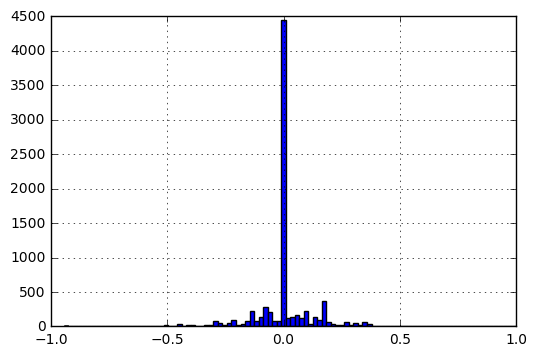

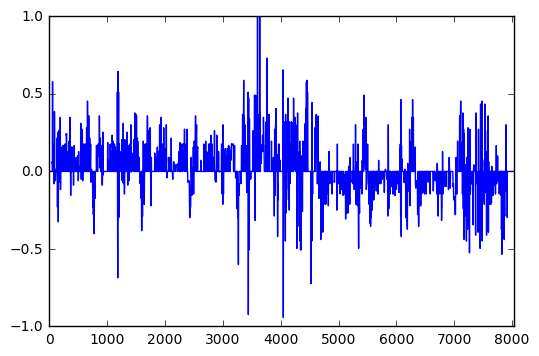

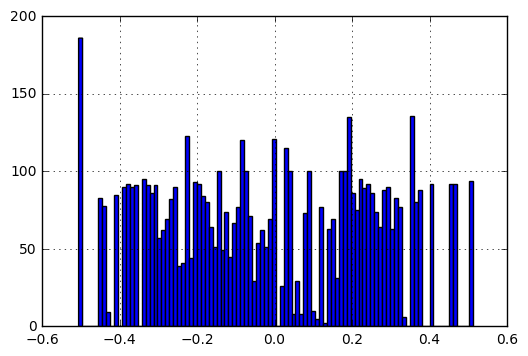

(4896, 4)
(1224, 4)


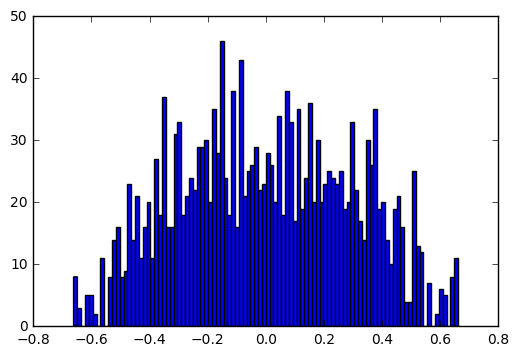

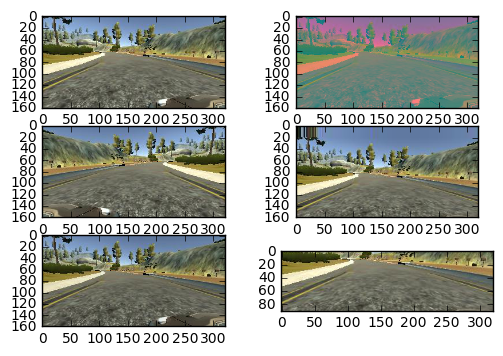

In [4]:
"""
Udacity self driving 
Project 3: behavioral cloning
Version 2.0
Xu fuqiang 
2017.03.01

Thanks for these following exciting blogs and great ideas.
https://medium.com/@ValipourMojtaba/my-approach-for-project-3-2545578a9319#.d12enp8g1
http://navoshta.com/end-to-end-deep-learning/
https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/46a70500-493e-4057-a78e-b3075933709d/concepts/b602658e-8a68-44e5-9f0b-dfa746a0cc1a
https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html
https://medium.com/@jmlbeaujour/self-driving-car-simulator-behavioral-cloning-p3-c9f4338c86b0#.7w3yf32sk
https://hackernoon.com/training-a-deep-learning-model-to-steer-a-car-in-99-lines-of-code-ba94e0456e6a#.ylivc7nb1
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
import sklearn
import os
import csv
import random
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img, random_shift
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Cropping2D
from keras.models import model_from_json
from keras.layers import Input, Lambda 
from keras.callbacks import EarlyStopping  
from keras.models import load_model
from keras.optimizers import Adam
from sklearn.utils import shuffle
from keras.layers.advanced_activations import ELU
from keras.regularizers import l2

# read csv file and data exploration 
names = ['center','left','right','steering','throttle','brake','speed']
data = pd.read_csv('./data/driving_log.csv', names=names)
data.steering = pd.to_numeric(data.steering, errors='coerce')
data.speed = pd.to_numeric(data.speed, errors='coerce')
# remove the first title row 
data = data.drop([0], axis=0) 
data = data[['center','left','right','steering']]

# 100 units to show Udacity steering angles frequency and data
data.steering.hist(bins=100) 
plt.show()
data.steering.plot()
plt.show()

# balance input data in pandas
#print(data.steering.value_counts())
balanced_data = pd.DataFrame()

# downsampling and oversampling in pandas
# only care for [-0.7, 0.7]
for angleunit in range(0,70,1):
    start_plus = angleunit/100.
    end_plus = start_plus + 1/100.
    # threshold 100
    # this is related to bins and optimized 
    thres = 100
    d_range = data[(data.steering < end_plus) & (data.steering >= start_plus)]
    # downsampling if larger than threshold 
    if len(d_range) >= thres:
        balanced_data = pd.concat([balanced_data, d_range.sample(thres)])
    elif len(d_range) < 5:
        pass
    else:
        # compare with len(d_range) and thres to oversampling
        aug = thres - d_range.shape[0]
        stp = max((min(aug, d_range.shape[0])// 2), 1)
        loop = aug // stp
        resid = aug % stp
        for i in range(loop):
            balanced_data = pd.concat([balanced_data, d_range.sample(stp)])
        balanced_data = pd.concat([balanced_data, d_range.sample(resid)])  

    start_neg = - angleunit/100.
    end_neg = start_neg - 1/100.
    d_range = data[(data.steering >= end_neg) & (data.steering < start_neg)]
    # downsampling if larger than threshold 
    if len(d_range) >= thres:
        balanced_data = pd.concat([balanced_data, d_range.sample(thres)])
    elif len(d_range) < 5:
        pass
    else:
        # compare with len(d_range) and threshold to oversampling
        aug = thres - d_range.shape[0]
        stp = max((min(aug, d_range.shape[0])// 2),1)
        loop = aug // stp
        resid = aug % stp
        for i in range(loop):
            balanced_data = pd.concat([balanced_data, d_range.sample(stp)])
        balanced_data = pd.concat([balanced_data, d_range.sample(resid)])   

# show balanced_data histogram 
balanced_data.steering.hist(bins=100)
plt.show()
#print(balanced_data.steering.value_counts())

# pandas to array and shuffle
# pandas into array 
in_samples = balanced_data.as_matrix() 
# shuffle
in_samples = shuffle(in_samples) 
# split train and test data
train_samples, validation_samples = train_test_split(in_samples, test_size=0.2) 
print(train_samples.shape)
print(validation_samples.shape)

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(90, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary_output

# This method transform the image to HSV and randomizes the V value to change the brightness.
# This will help our network. It will generate more easily and won't be affected by change in light conditions.
def randomize_brightness(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_brightness = .1 + np.random.uniform()
    image[:,:,2] = image[:,:,2] * random_brightness
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

# to random shift, BGR2YUV images, random birghtness adjustment 
def process_image(name):
    
    image = mpimg.imread(name)
    # random shift image
    image = random_shift(image, 0, 0.2, 0, 1, 2)   
    # random birghtness adjustment 
    image = randomize_brightness(image)
    
    return image

# generator
def generator(samples, batch_size=128, folder = './data/IMG/'):
    num_samples = len(samples)
    
    # Loop forever so the generator never terminates
    while 1: 
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []         
           
            for batch_sample in batch_samples:
                
                # center image
                center_image = str(folder + batch_sample[0].split('/')[-1])  
                # left image
                left_image = str(folder + batch_sample[1].split('/')[-1]) 
                # right image
                right_image = str(folder + batch_sample[2].split('/')[-1]) 
                # steering angle
                angle = float(batch_sample[3]) 
                
                # random to choose camera center, left or right 
                camera = random.choice([0,1,2])
                if camera == 0:
                    image = process_image(center_image)
                    f = 0
                elif camera == 1:                 
                    image = process_image(left_image)
                    f = 0.15          
                else:
                    image = process_image(right_image)
                    f = -0.15
                
                angle = angle + f
                
                # Flip 50% of the time
                if np.random.randint(2) == 0:
                    image = cv2.flip(image, 1)
                    angle = -angle
                
                images.append(image)
                angles.append(angle)
                
            # batch and shuffle 
            X_train = np.asarray(images)
            y_train = np.array(angles)
    
            yield sklearn.utils.shuffle(X_train, y_train)
            
# train and validation generator 
train_generator = generator(train_samples, batch_size=128, folder ='./data/IMG/')
validation_generator = generator(validation_samples, batch_size=128, folder = './data/IMG/')

# to show histogram of batches with generator
steeringAngleList = np.empty((0))
for i in range(15):
    steeringAngleList = np.append(steeringAngleList,next(train_generator)[1])
    
plt.hist(steeringAngleList.astype('float'), bins=100)
plt.show()

# pipeline fuctions on one image and show
name = './data/IMG/'+train_samples[0][1].split('/')[-1]
image = mpimg.imread(name)
yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
flip = cv2.flip(image,1)
plt.subplot(321)
plt.imshow(image, cmap='gray')
plt.subplot(322)
plt.imshow(yuv, cmap='gray')
plt.subplot(323)
plt.imshow(flip, cmap='gray')

shift = random_shift(image, 0, 0.2, 0, 1, 2) 
plt.subplot(324)
plt.imshow(shift, cmap='gray')

bright = randomize_brightness(image)
plt.subplot(325)
plt.imshow(bright, cmap='gray')

rimg = image[50:140,:,:] 
plt.subplot(326)
plt.imshow(rimg, cmap='gray')
plt.show()

In [5]:
# image size and channel 
row, col, ch = 160, 320, 3  

# epoch    
epoch = 15

# Model architecture
model = Sequential()
# cropping images 
model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(row,col,ch))) 
# normalization 90x320x3
model.add(Lambda(lambda x: (x / 255.0)- 0.5)) 
model.add(Convolution2D(24, 5, 5, activation='relu', subsample=(2, 2), border_mode='valid', init='he_normal'))
model.add(Convolution2D(36, 5, 5, activation='relu', subsample=(2, 2), border_mode='valid', init='he_normal'))
model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2, 2), border_mode='valid', init='he_normal'))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1, 1), border_mode='valid', init='he_normal'))
model.add(Convolution2D(64, 3, 3, activation='relu', subsample=(1, 1), border_mode='valid', init='he_normal'))
model.add(Flatten())
model.add(Dense(100, activation='relu', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu', init='he_normal'))
model.add(Dense(10, activation='relu', init='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(1, init='he_normal'))
model.compile(loss='mean_squared_error', optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=epoch, verbose=1)

# Save model
model.save("model.h5")
del model
print("Saved model to disk")

Epoch 1/15
4896/4896 [==============================] - 174s - loss: 0.0961 - val_loss: 0.0922
Epoch 2/15
4896/4896 [==============================] - 169s - loss: 0.0884 - val_loss: 0.0899
Epoch 3/15
4896/4896 [==============================] - 177s - loss: 0.0802 - val_loss: 0.0708
Epoch 4/15
4896/4896 [==============================] - 168s - loss: 0.0718 - val_loss: 0.0611
Epoch 5/15
4896/4896 [==============================] - 162s - loss: 0.0615 - val_loss: 0.0511
Epoch 6/15
4896/4896 [==============================] - 188s - loss: 0.0544 - val_loss: 0.0423
Epoch 7/15
4896/4896 [==============================] - 160s - loss: 0.0498 - val_loss: 0.0444
Epoch 8/15
4896/4896 [==============================] - 186s - loss: 0.0481 - val_loss: 0.0360
Epoch 9/15
4896/4896 [==============================] - 199s - loss: 0.0472 - val_loss: 0.0372
Epoch 10/15
4896/4896 [==============================] - 209s - loss: 0.0444 - val_loss: 0.0356
Epoch 11/15
4896/4896 [==========================

dict_keys(['val_loss', 'loss'])


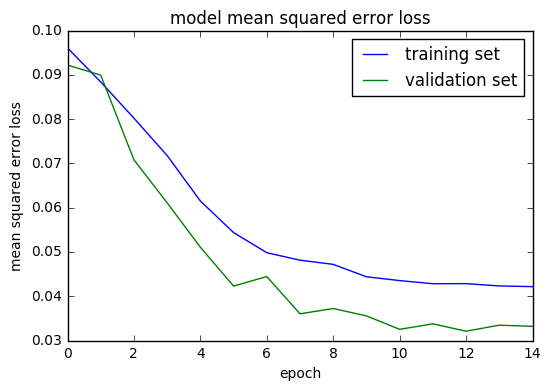

In [6]:
# print the keys contained in the history object
print(history_object.history.keys())

# plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [7]:
# epoch    
epoch = 10

# These below code is to continuous train model with small epochs and monitor train data influence on model behavior
# load  model
model = load_model('model.h5')
print("Loaded model from disk")

model.compile(loss='mean_squared_error', optimizer='adam')

history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=epoch,  verbose=1)

# Save model
model.save("model.h5")
del model
print("Saved model to disk")

Loaded model from disk
Epoch 1/10
4896/4896 [==============================] - 163s - loss: 0.0413 - val_loss: 0.0353
Epoch 2/10
4896/4896 [==============================] - 155s - loss: 0.0424 - val_loss: 0.0333
Epoch 3/10
4896/4896 [==============================] - 155s - loss: 0.0401 - val_loss: 0.0329
Epoch 4/10
4896/4896 [==============================] - 154s - loss: 0.0404 - val_loss: 0.0307
Epoch 5/10
4896/4896 [==============================] - 157s - loss: 0.0391 - val_loss: 0.0327
Epoch 6/10
4896/4896 [==============================] - 158s - loss: 0.0398 - val_loss: 0.0335
Epoch 7/10
4896/4896 [==============================] - 158s - loss: 0.0400 - val_loss: 0.0301
Epoch 8/10
4896/4896 [==============================] - 158s - loss: 0.0401 - val_loss: 0.0313
Epoch 9/10
4896/4896 [==============================] - 159s - loss: 0.0404 - val_loss: 0.0317
Epoch 10/10
4896/4896 [==============================] - 159s - loss: 0.0394 - val_loss: 0.0320
Saved model to disk


In [8]:
from keras.utils.visualize_util import plot
plot(model, to_file='model.png')

ImportError: No module named 'pydot'